In [1]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [2]:
#! pip install rdkit-pypi
# ! pip install rdkit
# ! pip install Chem
# from tensorflow.python import Keras
# from tensorflow import keras

In [3]:
# import Chem
# import rdkit 
# ! pip freeze -> requirement.txt

In [4]:
import pandas as pd
import numpy as np
from datagen import smiles_dict, smiles_to_seq

### smiles_dict

In [5]:
len(smiles_dict)

42

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [6]:
print(smiles_dict)

{'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [7]:
df = pd.read_csv('data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')

In [8]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [9]:
print(max_sequence_len)

227


In [10]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [11]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

In [12]:
X.shape, y.shape

((5664,), (5664,))

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [13]:
from dataaug import SmilesEnumerator
sme = SmilesEnumerator()
for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

C(c1ccccc1)Oc1cc(-n2nc(OCC)oc2=O)ccc1
O=c1oc(OCC)nn1-c1cc(OCc2ccccc2)ccc1
c1c(COc2cccc(-n3nc(OCC)oc3=O)c2)cccc1
c1c(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cccc1
n1(-c2cccc(OCc3ccccc3)c2)c(=O)oc(OCC)n1
c1c(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)cccc1
c1c(COc2cccc(-n3c(=O)oc(OCC)n3)c2)cccc1
c1cccc(COc2cccc(-n3c(=O)oc(OCC)n3)c2)c1
C(Oc1nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1)C
c1(COc2cccc(-n3c(=O)oc(OCC)n3)c2)ccccc1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [14]:
from datagen import DataGenerator

In [15]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [16]:
print(len(dgen))
len(dgen) * dgen.batch_size

354


5664

In [17]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
len(X_train), len(y_train), len(X_test)

(4531, 4531, 1133)

In [21]:
X_train

array(['COc1ccccc1NC(=S)NCCN(C)C', 'O/N=C/c1nc(Cc2ccccc2)no1',
       'O=C(NCCc1c[nH]c2ccccc12)c1ccc[n+](Cc2ccccc2F)c1.[Br-]', ...,
       'O=[N+]([O-])c1ccccc1-c1nnc(Nc2ncccn2)o1',
       'COc1cc2c(cc1O)CCC(C)(CCNCCCCCCCNc1c3c(nc4cc(Cl)ccc14)CCCC3)O2',
       'CN(C)Cc1ccc(CSCCCCCCCSCc2ccc(CN(C)C)o2)o1'], dtype=object)

In [22]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [23]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='') #Como queda el ultimo batchsize

In [24]:
X_b.shape

(109, 227)

# Network Model

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, GlobalAveragePooling1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras import layers as L

In [26]:
# MODELO 1
# Implementar modelo de TextCNN
# def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
#     # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
#     input_x = L.Input(shape=(sequence_length,), name='input_x')
#     embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
#     pooled_outputs = []
#     for filter_size in filter_sizes:
#         conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
#         max_p = L.MaxPool1D(100)(conv)
#         pooled_outputs.append(max_p)
        
#     h_pool = L.Concatenate(axis=2)(pooled_outputs)
#     dense = L.Flatten()(h_pool)
#     dense = L.Dense(128, activation='relu')(dense)
#     dense = L.Dense(32, activation='linear')(dense)
#     dense = L.Dense(1)(dense)
#     model = tf.keras.models.Model(input_x, dense)
#     return model

In [34]:
# MODELO 2
# Implementar modelo de TextCNN
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    max_pool_div = 4
    input_x = L.Input(shape=(sequence_length,), name='input_x')
    embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv) # 3 --> 56     4 --> 56     5 --> 55
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=2, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv) # 3 --> 56     4 --> 56     5 --> 55
        pooled_outputs.append(max_p)
        
        conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=3, activation='relu')(embedding)
        max_p = L.MaxPool1D((sequence_length - filter_size + 1)//max_pool_div)(conv) # 3 --> 56     4 --> 56     5 --> 55
        pooled_outputs.append(max_p)
        
        
        
    h_pool = L.Concatenate(axis=2)(pooled_outputs)
    dense = L.Flatten()(h_pool)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(100, activation='relu')(dense)
    dense = L.Dense(1)(dense)
    model = tf.keras.models.Model(input_x, dense)
    return model

In [35]:
# MODELO 3
# Implementar modelo de TextCNN
# def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
#     # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
#     max_pool_div = 4
#     input_x = L.Input(shape=(sequence_length,), name='input_x')
#     embedding = L.Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
#     pooled_outputs = []
#     for filter_size in filter_sizes:
#         conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
#         max_p = L.GlobalMaxPooling1D()(conv)
#         pooled_outputs.append(max_p)
        
#         conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='linear')(embedding)
#         max_p = L.GlobalMaxPooling1D()(conv)
#         pooled_outputs.append(max_p)
        
#         conv = L.Conv1D(filters=num_filters, kernel_size=filter_size, padding='same', dilation_rate=1, activation='relu')(embedding)
#         max_p = L.GlobalMaxPooling1D()(conv)
#         pooled_outputs.append(max_p)
        
        
#     # h_pool = L.Concatenate(axis=2 )(pooled_outputs)   
#     h_pool = L.Concatenate()(pooled_outputs)
#     # dense = L.Flatten()(h_pool)
#     dense = L.Dense(256, activation='relu')(h_pool)
#     dense = L.Dense(128, activation='linear')(dense)
#     dense = L.Dense(64, activation='linear')(dense)
#     dense = L.Dense(1)(dense)
#     model = tf.keras.models.Model(input_x, dense)
#     return model

In [36]:
# Puede cambiar estos hiperparámtros. Son solo de referencia
FILTER_SIZES = (3, 4, 5)
# FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
# NUM_FILTERS = 128
vocab_size = len(smiles_dict) #42
embeddings_size = 128 # 2
embeddings_size = 70 # 3
# sequence_length = 227

In [37]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_x (InputLayer)           [(None, 227)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 227, 70)      3010        ['input_x[0][0]']                
                                                                                                  
 conv1d_9 (Conv1D)              (None, 227, 128)     27008       ['embedding[0][0]']              
                                                                                                  
 conv1d_10 (Conv1D)             (None, 227, 128)     27008       ['embedding[0][0]']              
                                                                                            

In [38]:
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [39]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [40]:
mcp = ModelCheckpoint('models/best_model_{epoch}', save_best_only=True, save_format="h5")

In [41]:
# history = model.fit(dgen_train, epochs=10, validation_data=dgen_test)
history = model.fit(dgen_train, epochs=100, validation_data=dgen_test)

Epoch 1/100
36/36 [==============================] - 29s 761ms/step - loss: 25.9334 - R2: -9.1346 - val_loss: 12.8213 - val_R2: -3.5333
Epoch 2/100
36/36 [==============================] - 25s 688ms/step - loss: 4.6899 - R2: -0.8325 - val_loss: 3.0834 - val_R2: -0.0605
Epoch 3/100
36/36 [==============================] - 25s 685ms/step - loss: 2.6131 - R2: 0.0208 - val_loss: 2.9019 - val_R2: 0.0095
Epoch 4/100
36/36 [==============================] - 25s 688ms/step - loss: 2.5590 - R2: 0.0418 - val_loss: 2.8723 - val_R2: 0.0171
Epoch 5/100
36/36 [==============================] - 25s 688ms/step - loss: 2.5226 - R2: 0.0540 - val_loss: 2.8396 - val_R2: 0.0233
Epoch 6/100
36/36 [==============================] - 25s 685ms/step - loss: 2.4937 - R2: 0.0617 - val_loss: 2.8092 - val_R2: 0.0373
Epoch 7/100
36/36 [==============================] - 25s 687ms/step - loss: 2.4673 - R2: 0.0749 - val_loss: 2.7798 - val_R2: 0.0528
Epoch 8/100
36/36 [==============================] - 25s 686ms/step - 

In [42]:
X_test_eval = []
y_t_eval = []
for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

In [43]:
X_test_eval.shape, y_test.shape

((1133, 227), (1133,))

In [44]:
y_pred = model.predict(X_test_eval)

36/36 [==============================] - 2s 49ms/step


# Score

### PONER LOS SCORES ACA



In [45]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()

In [46]:
r2


0.5108227113660095

# Modelos corridos

In [47]:
# filename = 'models/embed_128_text_cnn_aug_100x100_0.0001.h5'
# filename = 'models/embed_128_text_cnn_aug_100x100_0.0002.h5'
# filename = 'models/embed_128_text_cnn_aug_100x100_0.0003.h5'
filename = 'models/embed_128_text_cnn_aug_100x100_0.0004.h5'
model.save(filename)

# Load model (solo si se grabo el modelo)

In [48]:
from tensorflow.keras.models import load_model

In [49]:
model_loaded = load_model(filename, custom_objects={'R2': R2})

In [50]:
y_pred = model_loaded.predict(X_test_eval)

36/36 [==============================] - 3s 66ms/step


In [51]:
r2 = 1 - ((y_test - y_pred.reshape(-1)) ** 2).sum() / ((y_test - y_test.mean()) ** 2).sum()
r2

0.5108227113660095

# Evaluación

<function matplotlib.pyplot.show(*args, **kw)>

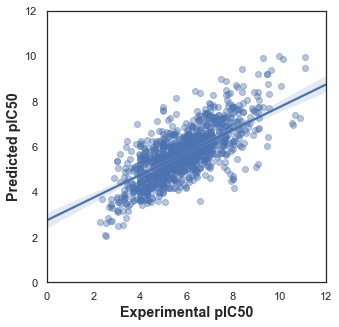

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

### TSNE 

In [53]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [54]:
embeddings = model.layers[1].get_weights()[0][1:]

In [55]:
embeddings.shape

(42, 70)

In [56]:
tsne = TSNE(2)
x_2d = tsne.fit_transform(embeddings)

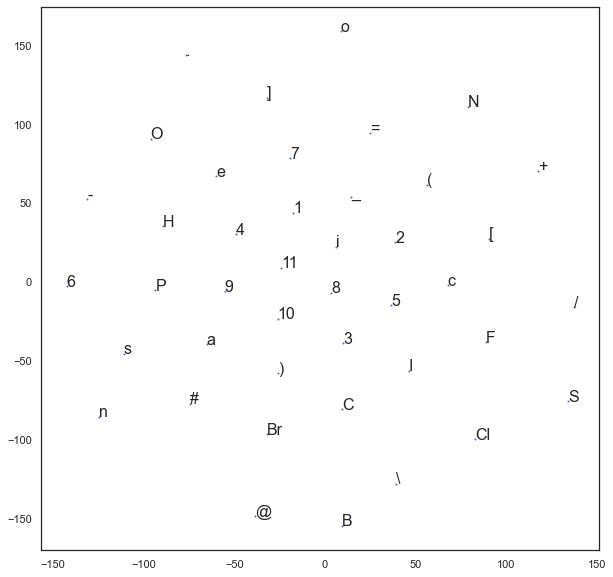

In [57]:
plt.figure(figsize=(10,10))
plt.scatter(x_2d[:, 0], x_2d[:, 1], s= 1)
for i, t in enumerate(smiles_dict):
    plt.text(x_2d[i, 0], x_2d[i, 1], t, fontsize=16)
    
plt.show()